## Import modules

In [497]:
# local
import DBSCAN as ds
import k_means as km

import numpy as np
import pandas as pd

from collections import Counter

# nltk 
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import stop_words as sw

# sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA


# data scraping
import itertools
import snscrape.modules.twitter as sc_twt

# visualisation
import seaborn as sns
import wordcloud as wc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

## Data Scrapping

In [498]:
def  scrape_and_save(search_str: str, file_name: str, num_tweets: int = 2000, slice: bool = True):

    scraped_tweets = sc_twt.TwitterSearchScraper(search_str).get_items()

    if(slice):
        sliced_scraped_tweets = itertools.islice(scraped_tweets, num_tweets)
        df = pd.DataFrame(sliced_scraped_tweets)
    else:
        df = pd.DataFrame(scraped_tweets)

    if df.empty == False:
        scr = pd.DataFrame.copy( df[['id', 'date', 'user', 'media', 'lang', 'content', 'hashtags', 'likeCount', 'replyCount', 'quoteCount']])

        scr['user_name'] = scr['user'].apply(lambda x: x['username'])
        scr['user_location'] =  scr['user'].apply(lambda x: x['location'])
        scr['user_isprotected'] = scr['user'].apply(lambda x: x['protected'])
        scr['user_isverified'] = scr['user'].apply(lambda x: x['verified'])

        scr = scr.drop(columns=['user'])

        print("num scraped tweets:" + str(scr.count()))
        print(scr.head(5))
        scr.to_csv(file_name)
    else:
        print("empty df")

In [499]:
# get tweets in english
from os.path import exists

tweets_file = "data/scraped_tweets.csv"
file_exists = exists(tweets_file)

if not file_exists:
    en_search = '(WorldCup OR WorldCup2022 OR FifaWorldCup) until:2022-11-10 lang:en'
    scrape_and_save(search_str = en_search, file_name = "data/scraped_tweets.csv", slice = True, num_tweets=60000)

## Data preprocessing

In [500]:
from os.path import exists

tweets_file = "data/tweets_processed.csv"
tweets_processed_file = exists(tweets_file)
tweets_processed_file

True

### Read data

In [501]:
if not tweets_processed_file:
    df_en_tweets = pd.read_csv("data/scraped_tweets.csv", delimiter=',')
    print(df_en_tweets.head(2))

### clean columns

#### Ensure that pl tweets in en are just in english

In [502]:
if not tweets_processed_file:
    df_en_tweets = df_en_tweets.loc[df_en_tweets['lang'] == 'en']
    df_en_tweets.info()

##### add new, simpler index

In [503]:
# create new index
if not tweets_processed_file:
    df_en_tweets.insert(0, 'ID', range(0, len(df_en_tweets)))
    df_en_tweets = df_en_tweets.set_index('ID')
    print(df_en_tweets.head(3))

In [504]:
if not tweets_processed_file:
    df_en_tweets = df_en_tweets[['lang', 'content', 'user_location']]
    print(df_en_tweets.head(3))

#### Encode location column

In [505]:
if not tweets_processed_file:
    oe = OrdinalEncoder()
    df_en_tweets['location'] = df_en_tweets['user_location']
    df_en_tweets['location'] = oe.fit_transform(np.array(df_en_tweets['location']).reshape(-1, 1))
    df_en_tweets = df_en_tweets.drop(columns = ['user_location'])
    df_en_tweets.info()

### Clean text content

In [506]:
if not tweets_processed_file:
    white_spaces = ["\r", "\n","\t", "    "]
    punctuation_signs = list("?:!.,;")
    special_characters = list("@#")


    df_en_tweets['content_clean_1'] = df_en_tweets['content']

    # whitespaces
    for char in white_spaces:
        df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace(char, " ")

    # quotation marks
    df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace('"', '')


    # puncuation signs
    for sign in punctuation_signs:
        df_en_tweets['content_clean_1'] = df_en_tweets['content_clean_1'].str.replace(sign, '')
    df_en_tweets.head()

In [507]:
if not tweets_processed_file:
    df_en_tweets.info()

In [508]:
if not tweets_processed_file:
   df_en_tweets = df_en_tweets.loc[df_en_tweets['content_clean_1'].str.contains("t20") == False]
   df_en_tweets = df_en_tweets.loc[df_en_tweets['content_clean_1'].str.contains("T20") == False]
   df_en_tweets = df_en_tweets.loc[df_en_tweets['content_clean_1'].str.contains("NFT") == False]
   df_en_tweets.info()

In [509]:
if not tweets_processed_file:
    hashtag_regex = "(#)(((\S)|(\d))*)"
    tag_regex = "(@)(((\S)|(\d))*)"
    link_regex = "(http)((\S|\d))*"

    df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_1'].str.replace(pat=hashtag_regex, repl= "")
    df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_2'].str.replace(pat=tag_regex, repl= "")
    df_en_tweets['content_clean_2'] = df_en_tweets['content_clean_2'].str.replace(pat=link_regex, repl= "")

In [510]:
if not tweets_processed_file:
        import re 
        emoji_regex = re.compile("["
                u"\U0001F600-\U0001F64F"  # emoticons
                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                u"\U00002500-\U00002BEF"  # chinese char
                u"\U00002702-\U000027B0"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u"\U00010000-\U0010ffff"
                u"\u2640-\u2642" 
                u"\u2600-\u2B55"
                u"\u200d"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\ufe0f"  # dingbats
                u"\u3030"
                        "]+", re.UNICODE)

        df_en_tweets['content_clean_3'] = df_en_tweets['content_clean_2'].str.replace(pat=emoji_regex, repl= " ")

In [511]:
if not tweets_processed_file:
    df_en_tweets['content_clean_3'] = df_en_tweets['content_clean_3'].str.replace("’s", "")
    df_en_tweets['content_clean_4'] = df_en_tweets['content_clean_3'].str.replace("'", "")
    df_en_tweets['content_clean_5'] = df_en_tweets['content_clean_4'].str.lower()
    print(df_en_tweets.head())

#### Lemmatize and remove stopwords

In [512]:
if not tweets_processed_file:
    lemmatizer = WordNetLemmatizer()
    stop_words_en = sw.get_stop_words(language="english")

    df_en_tweets['content_clean_6'] = df_en_tweets['content_clean_5']

    lemmatized_texts = []

    for row in df_en_tweets['content_clean_6']:
        text = row
        word_tokens = text.split(" ")

        lemmas  = []
        lemmatized_text = []

        for word in word_tokens:
            if word not in stop_words_en:
                lemmas.append(lemmatizer.lemmatize(word, pos = 'v'))

        lemmatized_text = " ".join(lemmas)

        lemmatized_texts.append(lemmatized_text)
        
    df_en_tweets['content_clean_7']= lemmatized_texts
    print(df_en_tweets.head())

In [513]:
if not tweets_processed_file:
    df_en_tweets = df_en_tweets[df_en_tweets['content_clean_7'].apply(lambda x: len(x.split(' ')) > 3)]
    df_en_tweets.info()

In [514]:
if not tweets_processed_file:
    df_en_tweets['text'] = df_en_tweets['content_clean_7']
    df_en = df_en_tweets[['text']]
    print(df_en.head())    

In [515]:
if not tweets_processed_file:
    df_en.to_csv("data/tweets_processed.csv")

## Data Analysis

In [516]:
tweets_df = pd.read_csv("data/tweets_processed.csv")
tweets_df.head()

ID                                               text
0   0   can never world cup uphold basic human right ...
1   1      french national team announce roster         
2   2  us mens national team  set roster world cup go...
3   3      sick joke now maddison tomori get man now    
4   4  update quote inter miami defender deandre yedl...

In [517]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49309 entries, 0 to 49308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      49309 non-null  int64 
 1   text    49309 non-null  object
dtypes: int64(1), object(1)
memory usage: 770.6+ KB


In [518]:
tweets_df = tweets_df.dropna()
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49309 entries, 0 to 49308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      49309 non-null  int64 
 1   text    49309 non-null  object
dtypes: int64(1), object(1)
memory usage: 770.6+ KB


In [519]:
def words_per_sample(list_of_texts: list):
    
    num_words = [len(s.split(' ')) for s in list_of_texts]
    return np.median(num_words)

def plot_sample_length_distr(sample_texts):
    """Plots the sample length distribution.
    """

    num_words = [len(s.split()) for s in sample_texts]
    plt.hist(num_words, 50)
    plt.xlabel('Length of a sample [words]')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

In [520]:
words_per_sample = words_per_sample(tweets_df["text"])
print(f"\n Median number of words per sample: {words_per_sample}")


 Median number of words per sample: 12.0


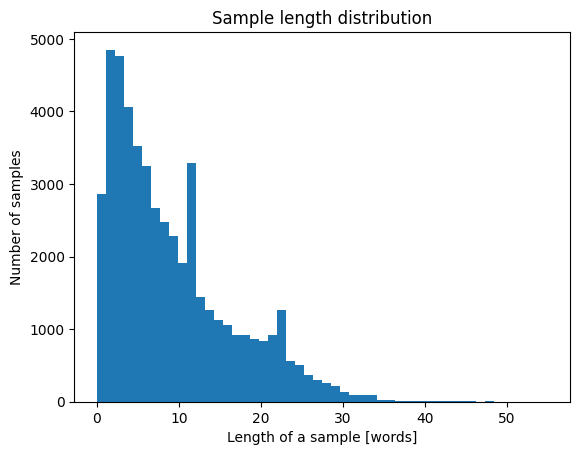

In [521]:
plot_sample_length_distr(tweets_df["text"])

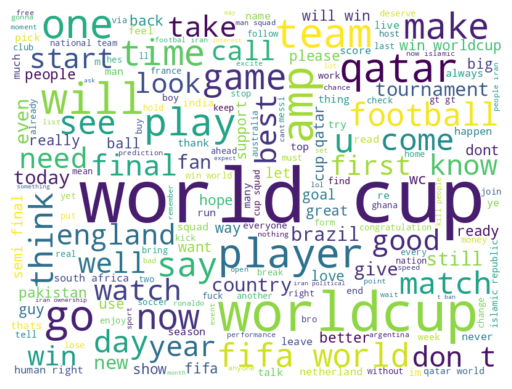

In [522]:
wordcloud = wc.WordCloud(background_color = 'white', width=800, height=600).generate(' '.join(tweets_df["text"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Tokenization and creating tweets embeddings

In [523]:
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
import torch

In [524]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MODEL = f"cardiffnlp/tweet-topic-21-multi"
# #tokenizer = AutoTokenizer.from_pretrained(MODEL)

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")

In [525]:
tweets_df['tokenized'] = ''
tweets_df['tokens'] = ''
tweets_df['attention_mask'] = ''

In [526]:
tokenized_data = tokenizer(tweets_df["text"].values.tolist(), padding=True, truncation=True)
tokenized_data[0]

Encoding(num_tokens=102, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [527]:
i = 0
for row in tweets_df.itertuples():

    tweets_df['tokenized'][i] = tokenized_data[i].ids
    tweets_df['tokens'][i] = tokenized_data[i].tokens
    tweets_df['attention_mask'][i] = tokenized_data[i].attention_mask
    i = i +1

/tmp/ipykernel_12020/4026262543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tokenized'][i] = tokenized_data[i].ids
/tmp/ipykernel_12020/4026262543.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tokens'][i] = tokenized_data[i].tokens
/tmp/ipykernel_12020/4026262543.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['attention_mask'][i] = tokenized_data[i].attention_mask


In [528]:
tweets_df.head()

ID                                               text  \
0   0   can never world cup uphold basic human right ...   
1   1      french national team announce roster            
2   2  us mens national team  set roster world cup go...   
3   3      sick joke now maddison tomori get man now       
4   4  update quote inter miami defender deandre yedl...   

                                           tokenized  \
0  [0, 2068, 2200, 2092, 2456, 27333, 3941, 2533,...   
1  [0, 2417, 2124, 2140, 14974, 9242, 2, 1, 1, 1,...   
2  [0, 2153, 2277, 2019, 2124, 2140, 2279, 9242, ...   
3  [0, 5309, 8261, 2089, 5510, 10525, 2243, 3423,...   
4  [0, 10655, 14690, 6974, 5635, 8295, 4674, 1620...   

                                              tokens  \
0  [<s>, can, never, world, cup, uphold, basic, h...   
1  [<s>, french, national, team, announce, roster...   
2  [<s>, us, men, ##s, national, team, set, roste...   
3  [<s>, sick, joke, now, mad, ##dis, ##on, tom, ...   
4  [<s>, update, quote, inter, miami, defender, d...   

                                      attention_mask  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...

In [529]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49309 entries, 0 to 49308
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              49309 non-null  int64 
 1   text            49309 non-null  object
 2   tokenized       49309 non-null  object
 3   tokens          49309 non-null  object
 4   attention_mask  49309 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [530]:
tweets_df = tweets_df[tweets_df['tokens'].apply(lambda x: len(x) > 3)]
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49309 entries, 0 to 49308
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              49309 non-null  int64 
 1   text            49309 non-null  object
 2   tokenized       49309 non-null  object
 3   tokens          49309 non-null  object
 4   attention_mask  49309 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


### Represent text as Doc2Vec

In [531]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tokenized_texts = tweets_df['tokens'].values.tolist()
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_texts)]
tagged_data[0:2]

[TaggedDocument(words=['<s>', 'can', 'never', 'world', 'cup', 'uphold', 'basic', 'human', 'right', 'put', 'athletes', 'whose', 'job', 'place', 'work', 'in', '##vid', '##ious', 'position', 'fear', 'identity', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], tags=[0]),
 TaggedDocument(words=['<s>', 'french', 'national', 

In [532]:
model = Doc2Vec(vector_size = 20, window = 2, min_count = 1, epochs = 100)

In [533]:
model.build_vocab(tagged_data)

In [534]:
from os.path import exists

model_file = "d2v.model"
file_exists = exists(model_file)

if file_exists:
    model = Doc2Vec.load(model_file)
else:
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    model.save(model_file)

In [535]:
embeddings = [model.infer_vector(d) for i, d in enumerate(tokenized_texts)]

In [536]:
embeddings[0]

array([-0.89749235, -0.5103115 ,  1.1194769 , -0.11209237,  1.2214272 ,
        0.7987132 ,  0.27985924,  1.289393  ,  1.8191334 , -0.9630285 ,
        0.5924539 , -0.05369132,  0.7777038 ,  0.05081645,  0.25853553,
        0.3343315 ,  1.1790214 ,  0.03503889,  0.19378208, -0.07665165],
      dtype=float32)

In [537]:
tweets_df['embeddings'] = embeddings

In [538]:
tweets_df.head()

ID                                               text  \
0   0   can never world cup uphold basic human right ...   
1   1      french national team announce roster            
2   2  us mens national team  set roster world cup go...   
3   3      sick joke now maddison tomori get man now       
4   4  update quote inter miami defender deandre yedl...   

                                           tokenized  \
0  [0, 2068, 2200, 2092, 2456, 27333, 3941, 2533,...   
1  [0, 2417, 2124, 2140, 14974, 9242, 2, 1, 1, 1,...   
2  [0, 2153, 2277, 2019, 2124, 2140, 2279, 9242, ...   
3  [0, 5309, 8261, 2089, 5510, 10525, 2243, 3423,...   
4  [0, 10655, 14690, 6974, 5635, 8295, 4674, 1620...   

                                              tokens  \
0  [<s>, can, never, world, cup, uphold, basic, h...   
1  [<s>, french, national, team, announce, roster...   
2  [<s>, us, men, ##s, national, team, set, roste...   
3  [<s>, sick, joke, now, mad, ##dis, ##on, tom, ...   
4  [<s>, update, quote, inter, miami, defender, d...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                          embeddings  
0  [-0.89749235, -0.5103115, 1.1194769, -0.112092...  
1  [0.7510883, -0.34451744, 0.6539557, -0.320652,...  
2  [0.6184422, 0.0054400833, -0.89875174, -0.3705...  
3  [-0.5484372, -0.64833206, -0.73955214, -0.8263...  
4  [-1.2297535, -0.17224365, -0.56172913, 0.37411...

## Experiments with DBSCAN

In [539]:
data = pd.DataFrame(tweets_df['embeddings'])
data.head()

embeddings
0  [-0.89749235, -0.5103115, 1.1194769, -0.112092...
1  [0.7510883, -0.34451744, 0.6539557, -0.320652,...
2  [0.6184422, 0.0054400833, -0.89875174, -0.3705...
3  [-0.5484372, -0.64833206, -0.73955214, -0.8263...
4  [-1.2297535, -0.17224365, -0.56172913, 0.37411...

### define helper functions

In [540]:
def reduce_dimensionality(df: pd.DataFrame, vec_col_name : str = 'embeddings'):
    data = df.copy()
    data = data.reset_index()
  
    pca = PCA(n_components=3)
    data['x1'] = pca.fit_transform(data[vec_col_name].values.tolist())[:,0]
    data['x2'] = pca.fit_transform(data[vec_col_name].values.tolist())[:,1]
    data['x3'] = pca.fit_transform(data[vec_col_name].values.tolist())[:,2]

    return data[['x1','x2','x3']]

In [541]:
def plot_clusters(data: pd.DataFrame, clusters: list, plt_title: str, plt_title_3d: str, dest_folder: str, save: bool = False):

    # create and save 2d clusters plot ####
    clusters_plt_2d = sns.scatterplot(x = data['x1'], y= data['x2'],hue=clusters,data=data)
    plt.title(plt_title)

    # save
    if save is True:
        fig1 = clusters_plt_2d.get_figure()
        fig1.savefig(f"{dest_folder}\{plt_title}.png")

    # create 3d clusters plot ####

    # axes instance
    fig2 = plt.figure(figsize=(6,6))
    ax = Axes3D(fig2, auto_add_to_figure=False)
    fig2.add_axes(ax)

    # plot
    sc = ax.scatter( data['x1'], data['x2'], data['x3'], s=40, c=clusters, marker='o')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')

    # legend
    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
    plt.title(plt_title_3d)

    # save
    if save is True:
        plt.savefig(f"{dest_folder}\{plt_title_3d}.png", bbox_inches='tight')

In [542]:
def apply_dbscan(data: pd.DataFrame, eps: int = 0.5, min_pts: int = 5, vec_col_name : str = 'embeddings', dist_measure: str = 'euclidean'):
    
    df = data.copy()
    
    df_cut = df[vec_col_name].apply(pd.Series)
    data_arr = np.array(df_cut)

    clusters, true_centers = ds.dbscan(data_arr, eps = eps, min_points=min_pts, dist_func=dist_measure)
    clusters_counter = Counter(clusters)

    return {'results': {'clusters': clusters, 'cluster_counter': clusters_counter, 'true_centers': true_centers}, 'df_cut': df_cut}

In [543]:
def get_reduced_df(df: pd.DataFrame, vec_col_name : str = 'embeddings'):
    # combine data back into one vector
    source_df = df.copy()
    source_df[vec_col_name] = source_df.values.tolist()

    # reduce dimensionality to 3
    reduced_df = reduce_dimensionality(source_df, vec_col_name)

    return reduced_df

### Experiments with input size, eps and min points params

#### input: first 2500 tweets

In [544]:
df_slice = data.loc[0:2499]
df_slice.count()

embeddings    2500
dtype: int64

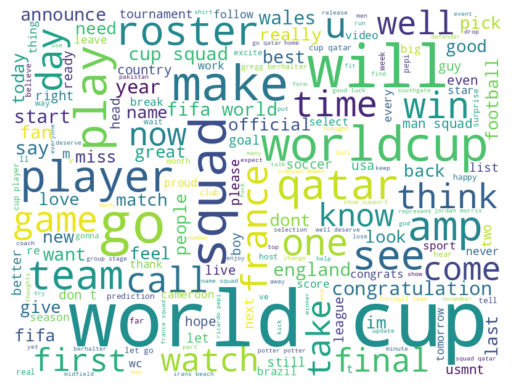

In [545]:
wordcloud = wc.WordCloud(background_color = 'white', width=800, height=600).generate(' '.join(tweets_df["text"][0:2499]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### attempt 1 : eps = 0.5, min_pts: 5

In [546]:
results = apply_dbscan(data = df_slice, eps = 0.5, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 2422, 1: 78})

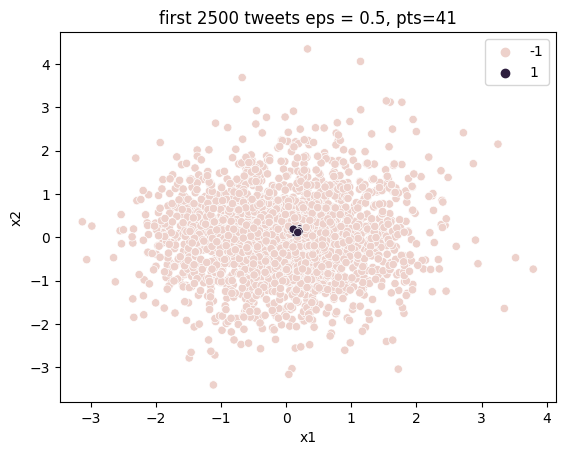

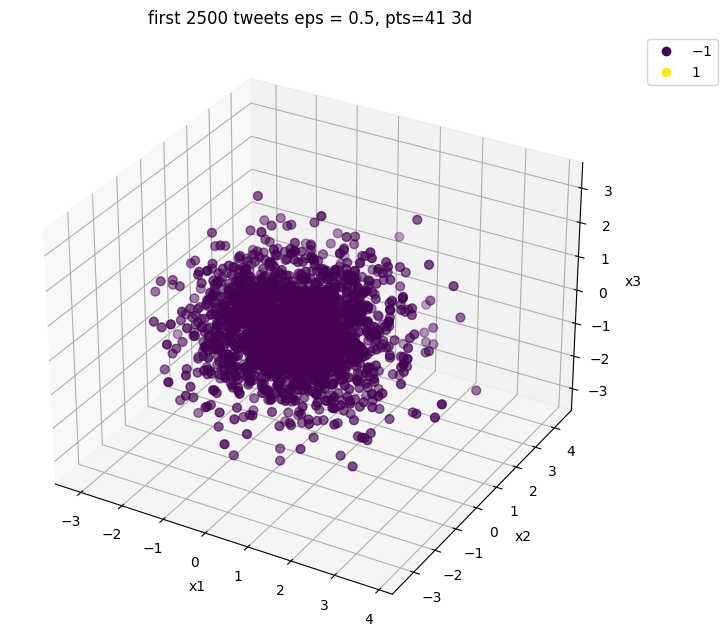

In [547]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 0.5, pts=41',
 plt_title_3d = 'first 2500 tweets eps = 0.5, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 2 : eps = 1, min_pts: 5

In [548]:
results = apply_dbscan(data = df_slice, eps = 1, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 2354, 2: 65, 1: 81})

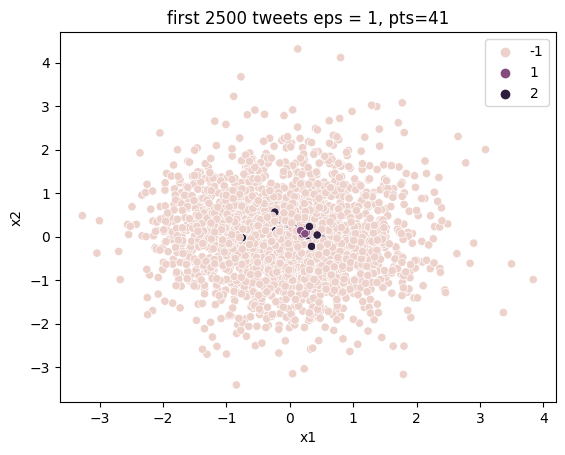

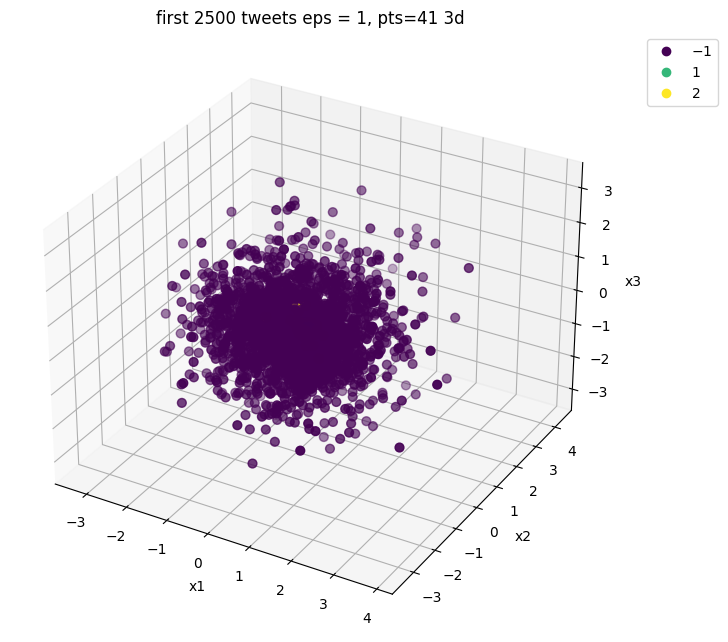

In [549]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 1, pts=41',
plt_title_3d = 'first 2500 tweets eps = 1, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 3 : eps = 1.5, min_pts: 5

In [550]:
results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 2131, 1: 369})

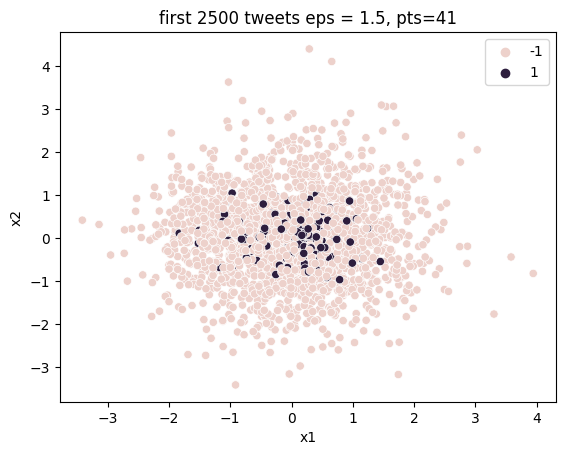

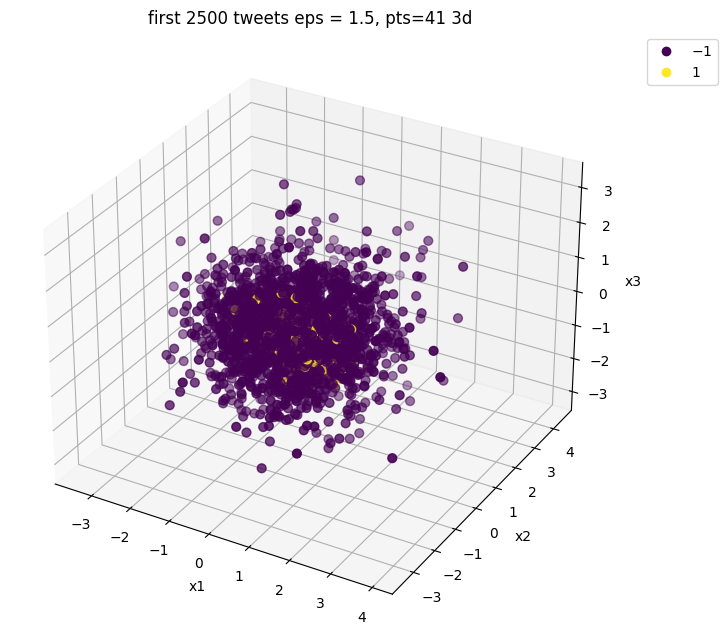

In [551]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 1.5, pts=41',
plt_title_3d = 'first 2500 tweets eps = 1.5, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 4 : eps = 2, min_pts: 5

In [552]:
results = apply_dbscan(data = df_slice, eps = 2, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 1372, 1: 1128})

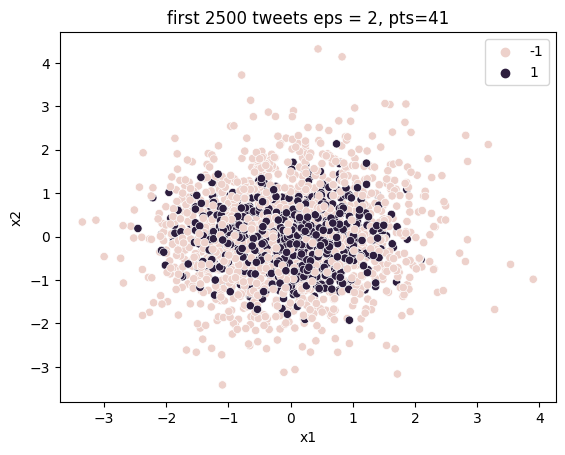

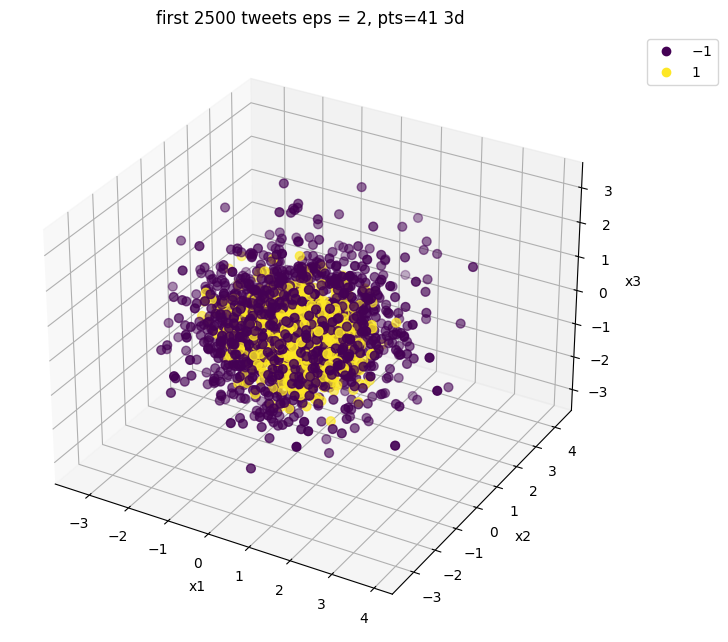

In [553]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 2500 tweets eps = 2, pts=41',
plt_title_3d = 'first 2500 tweets eps = 2, pts=41 3d', dest_folder = 'plots', save = True)

#### input: first 5000 tweets

In [554]:
df_slice = data.loc[0:4999]
df_slice.count()

embeddings    5000
dtype: int64

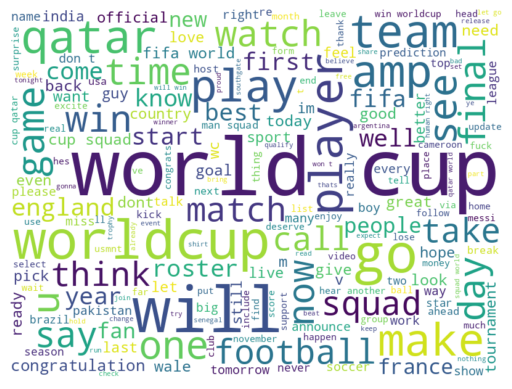

In [555]:
wordcloud = wc.WordCloud(background_color = 'white', width=800, height=600).generate(' '.join(tweets_df["text"][0:4999]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### attempt 1: eps = 0.5, min_pts = 5

In [556]:
results = apply_dbscan(data = df_slice, eps = 0.5, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4847, 1: 153})

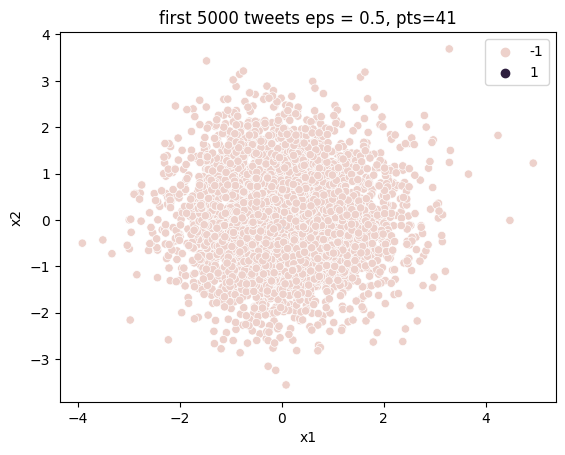

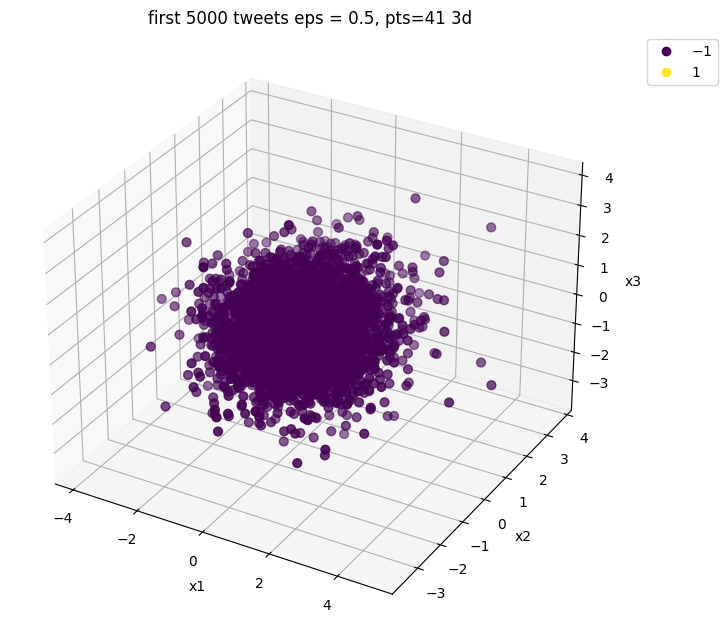

In [557]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 0.5, pts=41',
 plt_title_3d = 'first 5000 tweets eps = 0.5, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 2 : eps = 1, min_pts: 5

In [558]:
results = apply_dbscan(data = df_slice, eps = 1, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4687, 2: 153, 1: 160})

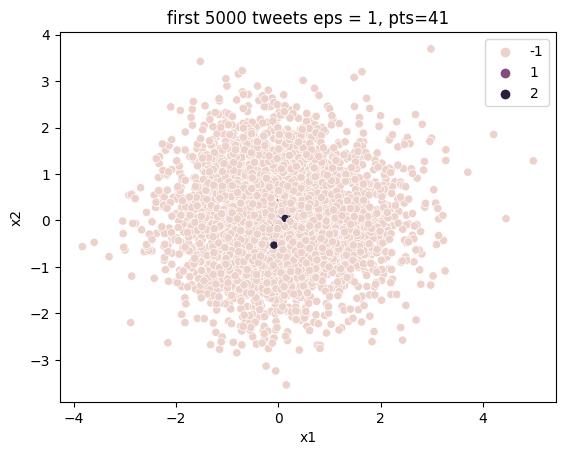

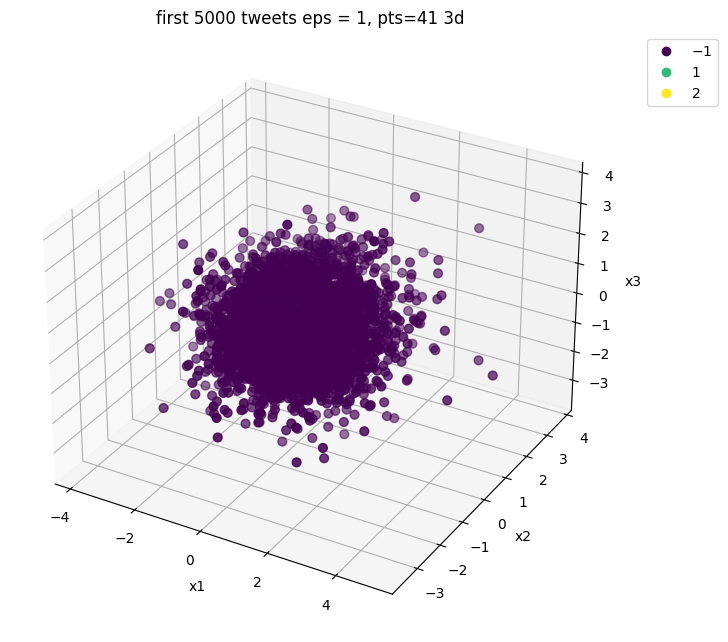

In [559]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 1, pts=41',
plt_title_3d = 'first 5000 tweets eps = 1, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 3 : eps = 1.5, min_pts: 5

In [560]:
results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4139, 1: 861})

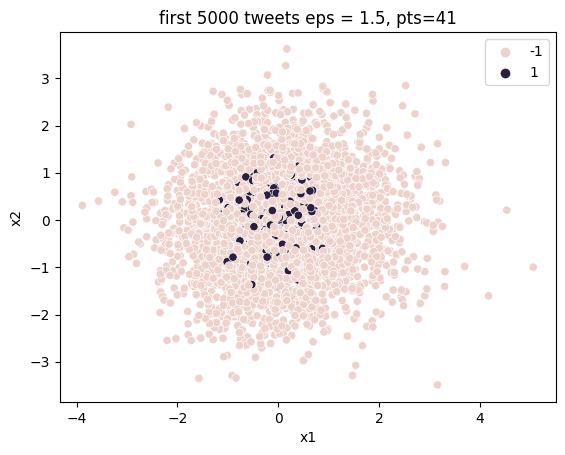

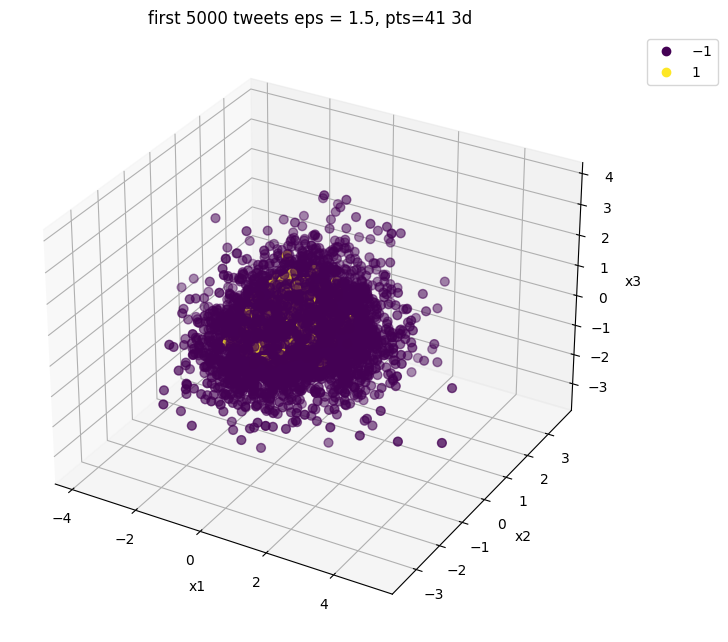

In [561]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 1.5, pts=41',
plt_title_3d = 'first 5000 tweets eps = 1.5, pts=41 3d', dest_folder = 'plots', save = True)

##### attempt 4 : eps = 2, min_pts: 5

In [562]:
results = apply_dbscan(data = df_slice, eps = 2, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 2597, 1: 2403})

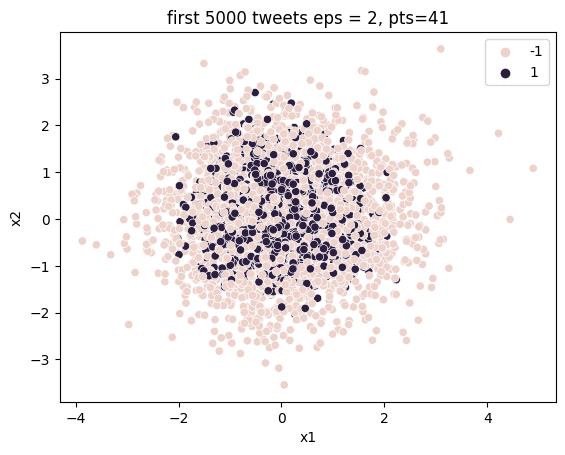

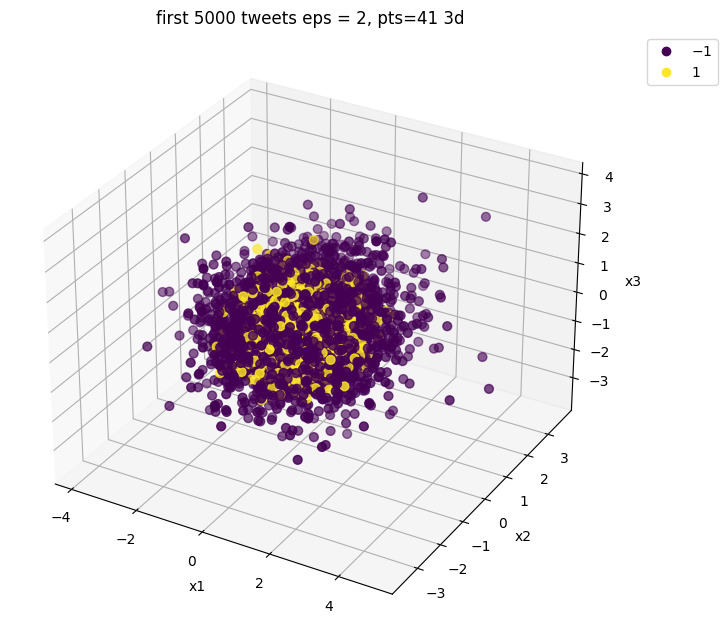

In [563]:
data_to_visualize = get_reduced_df(results['df_cut']) 
plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 2, pts=41',
plt_title_3d = 'first 5000 tweets eps = 2, pts=41 3d', dest_folder = 'plots', save = True)

In [564]:
results = apply_dbscan(data = df_slice, eps = 0.7, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4773, 1: 156, 2: 71})

In [565]:
results = apply_dbscan(data = df_slice, eps = 1, min_pts=41)
results['results']['cluster_counter']

Counter({-1: 4687, 2: 153, 1: 160})

In [566]:
# results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=41)
# results['results']['cluster_counter']

In [567]:
# results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=41)
# results['results']['cluster_counter']

#### input: first 15000 tweets

In [568]:
df_slice = data.loc[0:14999]
df_slice.count()

embeddings    15000
dtype: int64

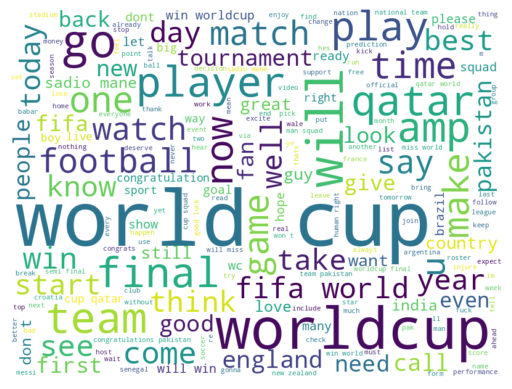

In [569]:
wordcloud = wc.WordCloud(background_color = 'white', width=800, height=600).generate(' '.join(tweets_df["text"][0:14999]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### eps = 1, min pts = 41

In [570]:
# results = apply_dbscan(data = df_slice, eps = 1, min_pts=41)
# results['results']['cluster_counter']

In [571]:
# data_to_visualize = get_reduced_df(results['df_cut']) 
# plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 15000 tweets eps = 1, pts=41',
#  plt_title_3d = 'first 15000 tweets eps = 1, pts=41 3d', dest_folder = 'plots', save = True)

##### eps = 1.5, min pts = 41

In [572]:
# results = apply_dbscan(data = df_slice, eps = 1.5, min_pts=41)
# results['results']['cluster_counter']

In [573]:
# data_to_visualize = get_reduced_df(results['df_cut']) 
# plot_clusters(data = data_to_visualize, clusters = results['results']['clusters'], plt_title = 'first 5000 tweets eps = 1.5, pts=41',
#  plt_title_3d = 'first 5000 tweets eps = 1.5, pts=41 3d', dest_folder = 'plots', save = True)

## K-means algorithm

In [574]:
df_slice = data.copy()
df_slice.count()

embeddings    49309
dtype: int64

In [575]:
df_slice.head()

embeddings
0  [-0.89749235, -0.5103115, 1.1194769, -0.112092...
1  [0.7510883, -0.34451744, 0.6539557, -0.320652,...
2  [0.6184422, 0.0054400833, -0.89875174, -0.3705...
3  [-0.5484372, -0.64833206, -0.73955214, -0.8263...
4  [-1.2297535, -0.17224365, -0.56172913, 0.37411...

In [588]:
df = df_slice.copy()

df_cut = df['embeddings'].apply(pd.Series)
data_arr = np.array(df_cut)

data_arr

array([[-0.89749235, -0.5103115 ,  1.1194769 , ...,  0.03503889,
         0.19378208, -0.07665165],
       [ 0.7510883 , -0.34451744,  0.6539557 , ..., -0.07136421,
         0.7749578 ,  0.65419537],
       [ 0.6184422 ,  0.00544008, -0.89875174, ..., -0.22130437,
         0.00881382,  0.37676913],
       ...,
       [-0.19085847, -0.07719038,  1.2788777 , ..., -1.1917495 ,
        -0.44917303, -0.39921907],
       [-0.5303751 , -0.5429303 ,  0.4952505 , ..., -0.4881801 ,
        -0.481902  , -0.0668302 ],
       [-0.2719104 , -0.75717795,  1.2301207 , ..., -1.048183  ,
        -0.22501439, -0.1149096 ]], dtype=float32)

In [589]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, n_init='auto', max_iter=10000, tol=0.1)
 
#predict the labels of clusters.
label = kmeans.fit_predict(data_arr)


[[-0.89749235 -0.5103115   1.1194769  ...  0.03503889  0.19378208
  -0.07665165]
 [ 0.7510883  -0.34451744  0.6539557  ... -0.07136421  0.7749578
   0.65419537]
 [ 0.6184422   0.00544008 -0.89875174 ... -0.22130437  0.00881382
   0.37676913]
 ...
 [-0.19085847 -0.07719038  1.2788777  ... -1.1917495  -0.44917303
  -0.39921907]
 [-0.5303751  -0.5429303   0.4952505  ... -0.4881801  -0.481902
  -0.0668302 ]
 [-0.2719104  -0.75717795  1.2301207  ... -1.048183   -0.22501439
  -0.1149096 ]]
[8 1 3 ... 0 4 4]


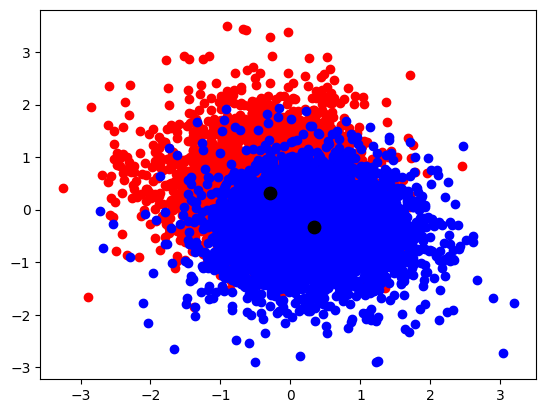

In [611]:
centroids = kmeans.cluster_centers_

#filter rows of original data
filtered_label2 = data_arr[label == 6]
filtered_label8 = data_arr[label == 9]
 
#Plotting the results
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'red')
plt.scatter(filtered_label8[:,0] , filtered_label8[:,1] , color = 'blue')
plt.scatter(centroids[6,0] , centroids[6,1] , s = 80, color = 'black')
plt.scatter(centroids[9,0] , centroids[9,1] , s = 80, color = 'black')
plt.show()


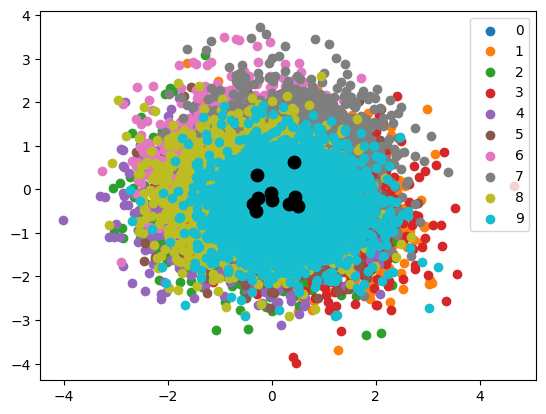

In [643]:
#Getting unique labels
u_labels = np.unique(label)
#plotting the results:
for i in u_labels:
    plt.scatter(data_arr[label == i , 0] , data_arr[label == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'black')
plt.legend()
plt.show()

In [594]:
df_slice_custom = data.copy()
df_slice_custom.count()

embeddings    49309
dtype: int64

In [595]:
df_cut_custom = df_slice_custom['embeddings'].apply(pd.Series)
data_arr_custom = np.array(df_cut_custom)

df_cut_custom.head()

0         1         2         3         4         5         6   \
0 -0.897492 -0.510311  1.119477 -0.112092  1.221427  0.798713  0.279859   
1  0.751088 -0.344517  0.653956 -0.320652  0.488592 -0.217085 -0.207125   
2  0.618442  0.005440 -0.898752 -0.370513  1.406959  0.640358 -0.265043   
3 -0.548437 -0.648332 -0.739552 -0.826368  0.635305  1.630883 -0.408383   
4 -1.229753 -0.172244 -0.561729  0.374110  1.324426  0.245619  0.754174   

         7         8         9         10        11        12        13  \
0  1.289393  1.819133 -0.963028  0.592454 -0.053691  0.777704  0.050816   
1  0.605510 -0.508045 -0.417870 -0.116813 -0.028076  0.126089 -0.024394   
2  1.600349 -0.900614  0.193800 -1.259412 -0.157613 -0.232726 -0.703034   
3  1.278723  0.206947 -1.397763  0.072055  0.443953  0.464310 -0.105808   
4  1.177933  0.724495 -1.239603 -1.109355 -0.492410  1.392996  1.148498   

         14        15        16        17        18        19  
0  0.258536  0.334332  1.179021  0.035039  0.193782 -0.076652  
1  0.936625  0.434890  0.770063 -0.071364  0.774958  0.654195  
2  0.064762 -0.435931  0.645722 -0.221304  0.008814  0.376769  
3  2.029634  0.459798 -0.140794  0.731031 -0.751333  0.762374  
4  0.703967 -1.292020  0.906191 -0.421243 -0.287472  1.359619

In [628]:
df_kmeans = df_slice.copy()

df_cut = df_kmeans['embeddings'].apply(pd.Series)
data_arr_custom = np.array(df_cut)

kmeans_custom = km.KMeans(clusters_number=10, max_iterations=10000)
kmeans_custom.fit(data_arr_custom)

centroids_custom, centroid_ids_list = kmeans_custom.group_centroids(data_arr_custom)

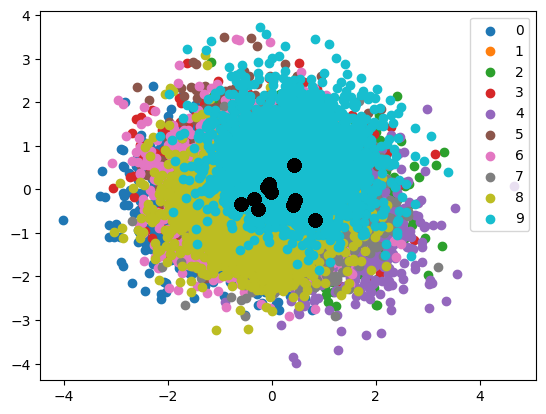

In [631]:
u_labels_custom = np.unique(centroid_ids_list)
centroids_custom = np.array(centroids_custom)

#plotting the results:
for i in u_labels_custom:
    plt.scatter(data_arr_custom[centroid_ids_list == i , 0] , data_arr_custom[centroid_ids_list == i , 1] , label = i)
    plt.scatter(centroids_custom[:,0] , centroids_custom[:,1] , s = 80, color = 'black')
plt.legend()
plt.show()

In [634]:
print(data_arr_custom[centroid_ids_list == 1])

[]


[[-0.89749235 -0.5103115   1.1194769  ...  0.03503889  0.19378208
  -0.07665165]
 [ 0.7510883  -0.34451744  0.6539557  ... -0.07136421  0.7749578
   0.65419537]
 [ 0.6184422   0.00544008 -0.89875174 ... -0.22130437  0.00881382
   0.37676913]
 ...
 [-0.19085847 -0.07719038  1.2788777  ... -1.1917495  -0.44917303
  -0.39921907]
 [-0.5303751  -0.5429303   0.4952505  ... -0.4881801  -0.481902
  -0.0668302 ]
 [-0.2719104  -0.75717795  1.2301207  ... -1.048183   -0.22501439
  -0.1149096 ]]
[[-0.47208348  0.04818791  0.6403307  ... -0.02354065  0.5065838
   0.3976884 ]
 [ 0.23724817  1.706782    1.1591301  ... -0.6415477   2.52297
   1.4519014 ]
 [-1.5351052   0.21946093  0.44830465 ... -1.4797958   0.8808919
   0.45736113]
 ...
 [ 0.5608393   0.7584047   0.9790375  ... -1.0027125  -0.5565121
  -0.00452579]
 [-1.0762949   0.5406128  -0.10819922 ...  0.12872018  0.7643169
   0.66133434]
 [ 1.0178466   0.8292846   3.0634215  ... -0.33435124  1.3651651
   0.2857203 ]]


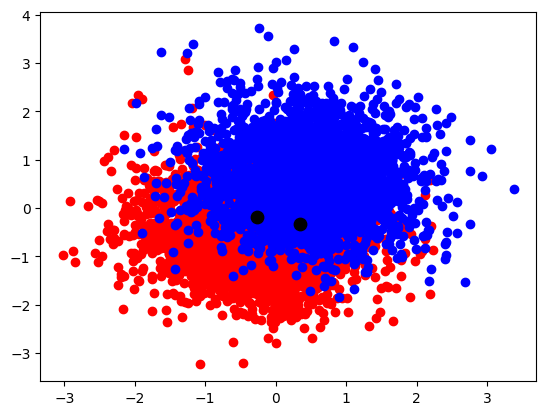

In [642]:
centroid_ids_list = np.array(centroid_ids_list)
filtered_label2_custom = data_arr_custom[centroid_ids_list == 8]
 
filtered_label8_custom = data_arr_custom[centroid_ids_list == 9]
 
#Plotting the results
plt.scatter(filtered_label2_custom[:,0] , filtered_label2_custom[:,1] , color = 'red')
plt.scatter(filtered_label8_custom[:,0] , filtered_label8_custom[:,1] , color = 'blue')
plt.scatter(centroids[8,0] , centroids[8,1] , s = 80, color = 'black')
plt.scatter(centroids[9,0] , centroids[9,1] , s = 80, color = 'black')
plt.show()